## Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import itertools
import dill
import missingno
from rff import RFF
from backtest_tc import Backtest_tc
from joblib import Parallel, delayed
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score, precision_score, recall_score, accuracy_score
from matplotlib import rc
pd.options.mode.chained_assignment = None  

## Load Environment (preloads results, optional)

In [1]:
import dill
dill.load_session('FXTCs.db')

## Import Data

In [ ]:
columns = ["cfabs", "cfcom", "cftw", "ir", "money", "cpi", "indprod"]
nber = pd.read_csv("data/NBER_20210719_cycle_dates_pasted.csv")[1:]
nber["peak"] = pd.to_datetime(nber["peak"])
nber["trough"] = pd.to_datetime(nber["trough"])
data_raw = pd.read_csv("data/mega.csv")
data_raw["yyyymm"] = pd.to_datetime(data_raw["yyyymm"], format='%Y%m', errors='coerce')
#data_raw["Index"] = data_raw["Index"].str.replace(",", "")
data_raw = data_raw.set_index("yyyymm")
data_raw[data_raw.columns] = data_raw[data_raw.columns].astype(float)
data_raw = data_raw.rename({"gbp":"returns"}, axis=1)
data_raw["lag_returns"] = data_raw["returns"].shift()
returns = data_raw["returns"].copy()## Import Data
data = data_raw[columns].dropna()
returns = returns[returns.index.isin(data.index)]

## Standardise

In [ ]:
for col in columns:
    data[col] = (data[col] - data[col].expanding(36).mean())/data[col].expanding(36).std()
returns_std = returns.rolling(12).std().shift()
returns = returns / returns_std
data = data[36:]
returns = returns[36:]

# Simulation

## Set parameters

In [ ]:
T = 12 #window
gammas = [0.1, 0.5, 1, 2, 4, 8, 16] #bandwidth parameter
z_values = list(np.logspace(-3, 3, 7)) #shrinkage

C_values = (
    list(np.logspace(-1, 0, 25, base=10)) +
    list(np.logspace(0, 1, 25, base=10)) +
    list(np.logspace(1, 2, 25, base=10)) +
    list(np.logspace(2, 3, 25, base=10))
) #logscale

P_values = [c*T for c in C_values] #no of features, creates double number listed as uses sin + cos
P_values = list({2*round(P/2) for P in P_values})
P_values.sort()

#control for seed
iterations = list(np.arange(1, 100))

In [ ]:
%%time
def simulation(data, returns, gamma, P, z, iteration):
    c = P/T
    rff_data = RFF(n=int(P/2), gamma=gamma).features(data, seed=iteration)
    sim = Backtest_tc(z=z, T=T).predict(X=rff_data, y=returns.shift(-1))
    performance = sim.performance()
    performance.update({"gamma": gamma, "P": P, "z": z, "c": c, "T": T, "iteration": iteration})
    return performance
#n_jobs = -1 means all cores minus one are used. Will cause significance performance drop for other tasks.
metrics = Parallel(n_jobs=-1)(delayed(simulation)(data, returns, gamma, P, z, iteration = seed) for gamma, P, z, seed in itertools.product(gammas, P_values, z_values, iterations))
metrics = pd.DataFrame(metrics)
metrics_mean = metrics.groupby(["gamma", "P", "z", "c", "T"]).mean().reset_index().drop("iteration", axis=1)
metrics_mean["log10(z)"] = np.log10(metrics_mean["z"])

# Results

In [ ]:
result = metrics_mean[(metrics_mean.gamma==0.5) & (metrics_mean.z==10**-3) & (metrics_mean.c == 1000)][["Alpha", "Expected Return", "Volatility","R2", "SR", "IR"]].max().to_dict()
#change result parameters to see performance of specific model specification

print("Our Results:")
for k,v in result.items():
    print(f"\t - {k}: {v}")
    
complexityall = metrics_mean[["c","z", "gamma","Expected Return", "Volatility", "R2", "SR", "IR"]]
complexityall.to_csv("FXTCscomplexityall.csv")

# Plots

In [8]:
#initiate tex backend for LaTeX graphs
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 24})
rc('text', usetex=True)

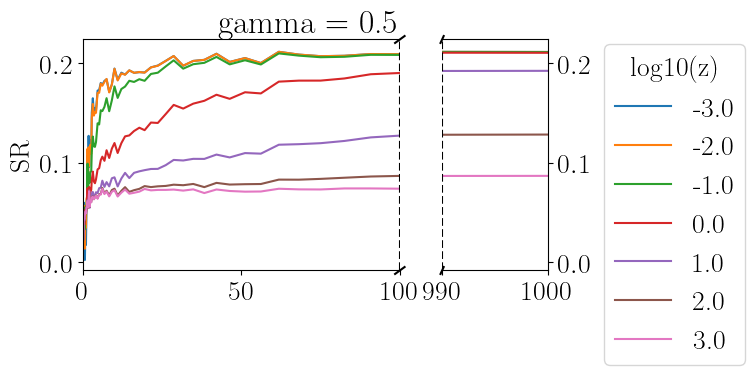

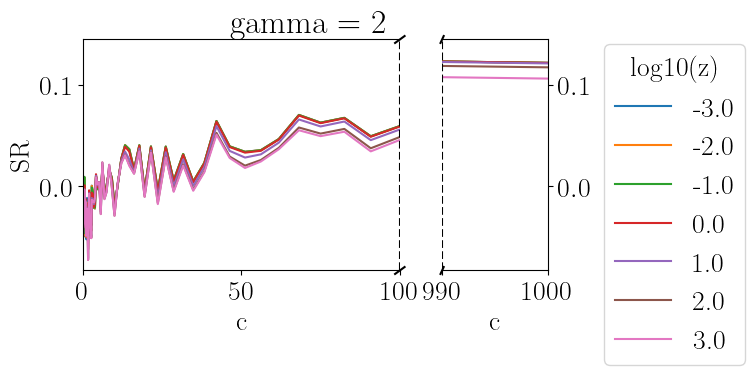

In [7]:
for gamma in [0.5, 2]:
    result = metrics_mean[metrics_mean["gamma"]==gamma]
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (6,3), width_ratios = [3,1])
    result.set_index("c").groupby("log10(z)")["SR"].plot(ax = ax1)
    result.set_index("c").groupby("log10(z)")["SR"].plot(ax = ax2)
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax1.set_xlim(0,100)
    ax2.set_xlim(990,1000)
    ax1.axvline(x=100, linestyle="--", c="black")
    ax2.axvline(x=990, linestyle="--", c="black")
    ax2.yaxis.tick_right()
    d = .015 
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((1-d,1+d), (-d,+d), **kwargs)
    ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)
    kwargs.update(transform=ax2.transAxes) 
    ax2.plot((-d,+d), (1-d,1+d), **kwargs)
    ax2.plot((-d,+d), (-d,+d), **kwargs)
    ax2.legend(loc="upper left", title="log10(z)", bbox_to_anchor=(1.4, 1.04))
    fig.add_subplot(ax1)
    fig.add_subplot(ax2)
    ax1.set_ylabel("SR")
    if gamma == 0.5:
        ax1.set_xlabel('')
        ax2.set_xlabel('')
    fig.suptitle(f"gamma = {gamma}")
    fig.savefig(f"FX{gamma}TCs.pdf", dpi = 1200, bbox_inches='tight')

# Gamma

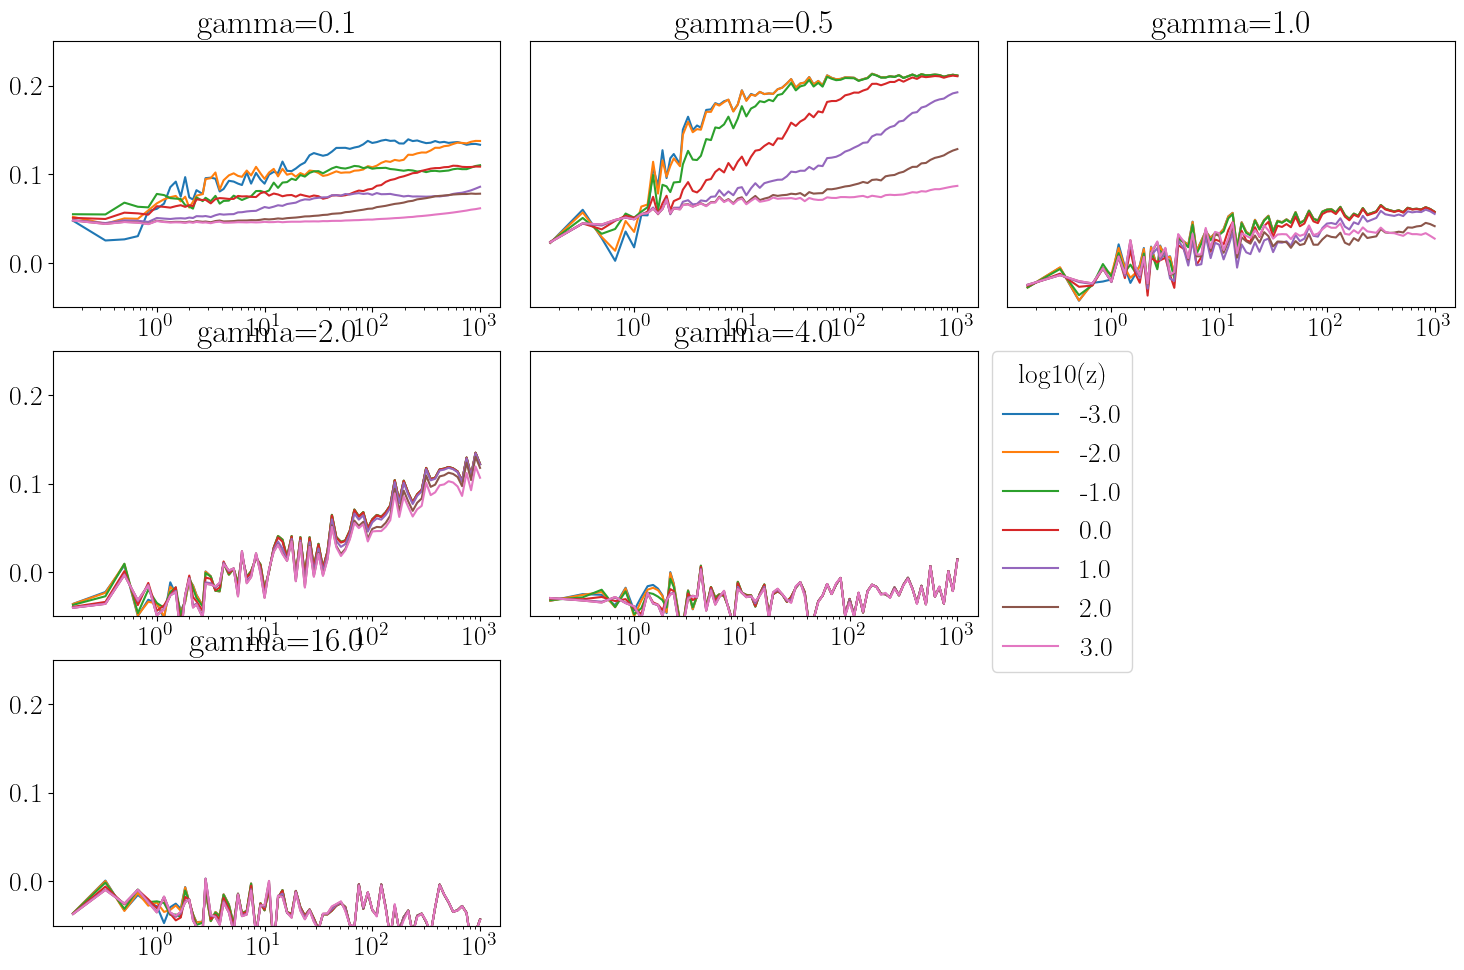

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,7))
fig.delaxes(axs[2,1])
fig.delaxes(axs[2,2])
axs = axs.flatten()
for i, gamma in enumerate(metrics_mean["gamma"].unique()):
    metrics_mean[metrics_mean["gamma"]==gamma].set_index("c").groupby("log10(z)")["SR"].plot(ax=axs[i], title=f"gamma={gamma}")
    axs[i].set_xscale('log')
    axs[i].set_xlabel('')
    axs[i].set_ylim(-0.05, 0.25)
    if gamma not in [0.1, 2, 16]:
        axs[i].set_yticks([])
axs[4].legend(loc="upper left", title="log10(z)", bbox_to_anchor=(1, 1.05))
fig.delaxes(axs[5])
#fig.suptitle(col)
fig.canvas.draw()
plt.tight_layout(pad = -4.5)
plt.savefig("GWNOTCGAMMA.pdf", dpi = 1200)
plt.show()

# Market Timing positions vs NBER Recessions

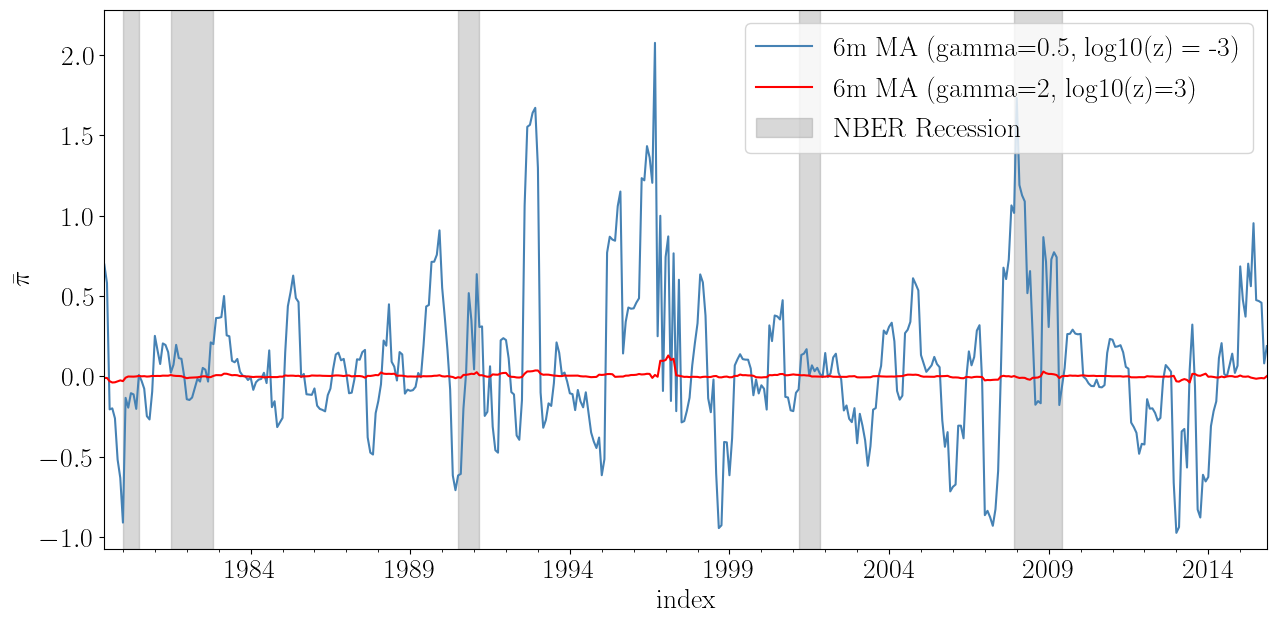

In [3]:
pd.options.mode.chained_assignment = None 

def merge_and_average_lists(nested_lists):
    sum_list = [0] * len(nested_lists[0])
    for nested_list in nested_lists:
        for i, value in enumerate(nested_list):
            sum_list[i] += value
    num_nested_lists = len(nested_lists)
    averaged_list = [sum_value / num_nested_lists for sum_value in sum_list]
    return averaged_list

##############################################################

backtest_1 = []
rff_data_1 = RFF(n=6000, gamma=0.5).features(data)
for a in range(1,100):
    backtest_temp_1 = Backtest_tc(z=10**-3, T=12).predict(X=rff_data_1, y=returns.shift(-1))
    backtest_temp_1 = backtest_temp_1.backtest
    backtest_1.append(backtest_temp_1)

timing_strategy_avg_1 = []
for b in range(1, len(backtest_1)):
    timing_strategy_avg_1.append(backtest_1[b]["timing_strategy"])
    
averaged_list_1 = merge_and_average_lists(timing_strategy_avg_1)
index_list_1 = backtest_1[1]["timing_strategy"].index
averaged_series_1 = pd.Series(averaged_list_1, index=index_list_1)

##############################################################

backtest_2= []
rff_data_2 = RFF(n=6000, gamma=2).features(data)
for a in range(1,100):
    backtest_temp_2 = Backtest_tc(z=10**3, T=12).predict(X=rff_data_2, y=returns.shift(-1))
    backtest_temp_2 = backtest_temp_2.backtest
    backtest_2.append(backtest_temp_2)

timing_strategy_avg_2 = []
for b in range(1, len(backtest_2)):
    timing_strategy_avg_2.append(backtest_2[b]["timing_strategy"])
    
averaged_list_2 = merge_and_average_lists(timing_strategy_avg_2)
index_list_2 = backtest_2[1]["timing_strategy"].index
averaged_series_2 = pd.Series(averaged_list_2, index=index_list_2)

plot_data = pd.DataFrame()
plot_data["timing_strategy_1"] = averaged_series_1
plot_data["timing_strategy_2"] = averaged_series_2
plot_data["6m MA (gamma=0.5, log10(z) = -3)"] = plot_data["timing_strategy_1"].rolling(6).mean()
plot_data["6m MA (gamma=2, log10(z)=3)"] = plot_data["timing_strategy_2"].rolling(6).mean()


recessions = [t for date_list in nber.apply(lambda x: pd.date_range(x["peak"], x["trough"]), axis=1).values for t in date_list]
plot_data["NBER Recession"] = plot_data.index.isin(recessions).astype(int)

plot_data = plot_data.dropna()

fig, ax = plt.subplots(figsize=(15,7))
#plot_data[col].plot(ax=ax, alpha=0.7, c="lightblue")
plot_data["6m MA (gamma=0.5, log10(z) = -3)"].plot(ax=ax, c="steelblue")
plot_data["6m MA (gamma=2, log10(z)=3)"].plot(ax=ax, c="red")
ax.set_ylim(min(plot_data["6m MA (gamma=0.5, log10(z) = -3)"].min()*1.1, plot_data["6m MA (gamma=2, log10(z)=3)"].min()*1.1), max(plot_data["6m MA (gamma=0.5, log10(z) = -3)"].max()*1.1, plot_data["6m MA (gamma=2, log10(z)=3)"].max()*1.1))
ax.fill_between(plot_data.index, ax.get_ylim()[0], ax.get_ylim()[1], 
                where=plot_data["NBER Recession"] == 1 ,color='grey', alpha=0.3,  label="NBER Recession")
ax.legend(loc="upper right")
ax.set_ylabel(r"$\bar{\pi}$")
plt.savefig("FXdualplot.pdf", dpi = 1200)
plt.show()

## MT Tests

In [9]:
backtest_1[1]["timing_strategy"] = averaged_series_1
backtest_1[1].to_csv("backtest_1.csv")

from rpy2 import robjects
robjects.r(''' if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, lubridate, readr, timetk, tidyquant,
               broom, xts, PerformanceAnalytics, tibbletime,
               tidymodels, data.table)
setwd("C:/Users/Josh/OneDrive - University of Cambridge/Dissertation/replicating_the_virtue_of_complexity_in_machine_learning_portfolios-main/replicating_the_virtue_of_complexity_in_machine_learning_portfolios-main")

backtest = read_csv("backtest_1.csv")

backtest = backtest %>%
  tk_xts(select = -index, date_var = index)

portfolio = backtest$timing_strategy
benchmark = backtest$market_return
benchmark_sq = benchmark^2

reg_TM = lm(portfolio ~ benchmark + benchmark_sq)
results_TM = summary(reg_TM)
cat("TM = ", results_TM[["coefficients"]][3,3], "\n")

D = pmax(0, -benchmark)
reg_HM = lm(portfolio ~ benchmark + D)
results_HM = summary(reg_HM)
cat("HM = ", results_HM[["coefficients"]][3,3], "\n")

''')

R[write to console]: 
R[write to console]: indexing backtest_1.csv [===================================] 2.15GB/s, eta:  0s
                                                                                                                   
R[write to console]: 


Rows: 444 Columns: 7
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
dbl  (6): beta_norm, forecast, timing_strategy, market_return, delta, ptcdelta
date (1): index

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
TM =  9.038577 
HM =  6.717461 


In [10]:
backtest_2[1]["timing_strategy"] = averaged_series_2
backtest_2[1].to_csv("backtest_2.csv")

from rpy2 import robjects
robjects.r(''' if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, lubridate, readr, timetk, tidyquant,
               broom, xts, PerformanceAnalytics, tibbletime,
               tidymodels, data.table)
setwd("C:/Users/Josh/OneDrive - University of Cambridge/Dissertation/replicating_the_virtue_of_complexity_in_machine_learning_portfolios-main/replicating_the_virtue_of_complexity_in_machine_learning_portfolios-main")

backtest = read_csv("backtest_2.csv")

backtest = backtest %>%
  tk_xts(select = -index, date_var = index)

portfolio = backtest$timing_strategy
benchmark = backtest$market_return
benchmark_sq = benchmark^2

reg_TM = lm(portfolio ~ benchmark + benchmark_sq)
results_TM = summary(reg_TM)
cat("TM = ", results_TM[["coefficients"]][3,3], "\n")

D = pmax(0, -benchmark)
reg_HM = lm(portfolio ~ benchmark + D)
results_HM = summary(reg_HM)
cat("HM = ", results_HM[["coefficients"]][3,3], "\n")

''')

R[write to console]: 
R[write to console]: indexing backtest_2.csv [===================================] 2.15GB/s, eta:  0s
                                                                                                                   
R[write to console]: 


Rows: 444 Columns: 7
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
dbl  (6): beta_norm, forecast, timing_strategy, market_return, delta, ptcdelta
date (1): index

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
TM =  4.10682 
HM =  3.410912 


# WILL RESET ENVIRONMENT SAVE IF RUN, BE CAREFUL ->

In [ ]:
dill.dump_session('FXTCs.db')